<a href="https://colab.research.google.com/github/joaomigueld3/natural-language-processing/blob/main/desafio_pso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Função Rastrigin em 30 dimensões como função de benchmark:

f(x) = 10n + Σ [x_i² - 10cos(2πx_i)]

Onde n=30 (dimensões) e x_i ∈ [-5.12, 5.12]

##Implementação do PSO com Diferentes Topologias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time

class PSO:
    def __init__(self, objective_func, dimensions=30, particles=50, iterations=1000,
                 topology='global', w=0.729, c1=1.49445, c2=1.49445):
        self.objective_func = objective_func
        self.dimensions = dimensions
        self.particles = particles
        self.iterations = iterations
        self.topology = topology
        self.w = w  # # peso de inércia
        self.c1 = c1  # coeficiente cognitivo
        self.c2 = c2  # coeficiente social

        # Inicializar partículas
        self.positions = np.random.uniform(-5.12, 5.12, (particles, dimensions))
        self.velocities = np.random.uniform(-1, 1, (particles, dimensions))
        self.pbest_positions = self.positions.copy()
        self.pbest_values = np.array([float('inf')] * particles)

        # Inicializar topologia
        if topology == 'global':
            self.gbest_position = np.zeros(dimensions)
            self.gbest_value = float('inf')
        elif topology == 'ring':
            self.neighbors = []
            for i in range(particles):
                self.neighbors.append([(i-1) % particles, i, (i+1) % particles])
        elif topology == 'star':
            self.star_center = 0  # a partícula 0 é o centro

        self.convergence = []

    def evaluate(self):
        for i in range(self.particles):
            fitness = self.objective_func(self.positions[i])
            if fitness < self.pbest_values[i]:
                self.pbest_values[i] = fitness
                self.pbest_positions[i] = self.positions[i].copy()

            # Atualizar melhor global ou local com base na topologia
            if self.topology == 'global':
                if fitness < self.gbest_value:
                    self.gbest_value = fitness
                    self.gbest_position = self.positions[i].copy()
            elif self.topology == 'ring':
                best_neighbor = min(self.neighbors[i], key=lambda x: self.pbest_values[x])
                if self.pbest_values[i] < self.pbest_values[best_neighbor]:
                    best_neighbor = i
                # Nenhum gbest real no anel, apenas para rastreamento de convergência
                current_best = min(self.pbest_values)
            elif self.topology == 'star':
                if fitness < self.pbest_values[self.star_center]:
                    self.star_center = i
                # Nenhum gbest real na estrela, apenas para rastreamento de convergência
                current_best = self.pbest_values[self.star_center]

        # Convergência de trilhas (melhor valor encontrado até agora)
        if self.topology == 'global':
            self.convergence.append(self.gbest_value)
        else:
            self.convergence.append(current_best)

    def update_velocities(self):
        for i in range(self.particles):
            if self.topology == 'global':
                social_component = self.gbest_position - self.positions[i]
            elif self.topology == 'ring':
                best_neighbor = min(self.neighbors[i], key=lambda x: self.pbest_values[x])
                social_component = self.pbest_positions[best_neighbor] - self.positions[i]
            elif self.topology == 'star':
                social_component = self.pbest_positions[self.star_center] - self.positions[i]

            cognitive_component = self.pbest_positions[i] - self.positions[i]

            r1 = np.random.random(self.dimensions)
            r2 = np.random.random(self.dimensions)

            self.velocities[i] = (self.w * self.velocities[i] +
                                  self.c1 * r1 * cognitive_component +
                                  self.c2 * r2 * social_component)

    def update_positions(self):
        self.positions += self.velocities
        # Verificação de limites
        self.positions = np.clip(self.positions, -5.12, 5.12)

    def optimize(self):
        for _ in range(self.iterations):
            self.evaluate()
            self.update_velocities()
            self.update_positions()
        return self.convergence

def rastrigin(x):
    return 10*len(x) + sum([(xi**2 - 10*np.cos(2*np.pi*xi)) for xi in x])

##Execução do Experimento
30 execuções independentes para cada topologia

In [ ]:
def run_experiment(topology, runs=30):
    results = []
    convergence_data = []

    for _ in range(runs):
        pso = PSO(rastrigin, dimensions=30, particles=50, iterations=1000, topology=topology)
        convergence = pso.optimize()

        if topology == 'global':
            results.append(pso.gbest_value)
        elif topology == 'ring':
            results.append(min(pso.pbest_values))
        elif topology == 'star':
            results.append(pso.pbest_values[pso.star_center])

        convergence_data.append(convergence)

    # Calculate average convergence
    avg_convergence = np.mean(convergence_data, axis=0)

    return results, avg_convergence

# Run experiments for all topologies
topologies = ['global', 'ring', 'star']
all_results = {}
convergence_curves = {}

for topology in topologies:
    print(f"Running {topology} topology...")
    results, avg_convergence = run_experiment(topology)
    all_results[topology] = results
    convergence_curves[topology] = avg_convergence

Running global topology...
Running ring topology...
Running star topology...


##Análise Estatística

In [ ]:
# Estatísticas básicas
for topology, results in all_results.items():
    print(f"\n{topology.capitalize()} Topology:")
    print(f"  Best: {np.min(results):.4f}")
    print(f"  Worst: {np.max(results):.4f}")
    print(f"  Mean: {np.mean(results):.4f}")
    print(f"  Std Dev: {np.std(results):.4f}")

# Teste estatístico (Kruskal-Wallis para dados não paramétricos)
print("\nTeste estatístico (Kruskal-Wallis):")
stat, p = stats.kruskal(*all_results.values())
print(f"  H-statistic: {stat:.4f}")
print(f"  p-value: {p:.4f}")
if p < 0.05:
    print("  Teste estatístico (Kruskal-Wallis para dados não paramétricos) (p < 0.05)")
    # Post-hoc tests
    from itertools import combinations
    for t1, t2 in combinations(topologies, 2):
        stat, p = stats.mannwhitneyu(all_results[t1], all_results[t2])
        print(f"  {t1} vs {t2}: p-value = {p:.4f}")
else:
    print("  Nenhuma diferença significativa entre topologias")


Global Topology:
  Best: 30.8437
  Worst: 192.2393
  Mean: 111.8045
  Std Dev: 32.5595

Ring Topology:
  Best: 56.1985
  Worst: 145.3271
  Mean: 98.2412
  Std Dev: 21.7810

Star Topology:
  Best: 47.7580
  Worst: 204.1788
  Mean: 112.5460
  Std Dev: 33.2991

Teste estatístico (Kruskal-Wallis):
  H-statistic: 4.9925
  p-value: 0.0824
  Nenhuma diferença significativa entre topologias


##Análise de convergência

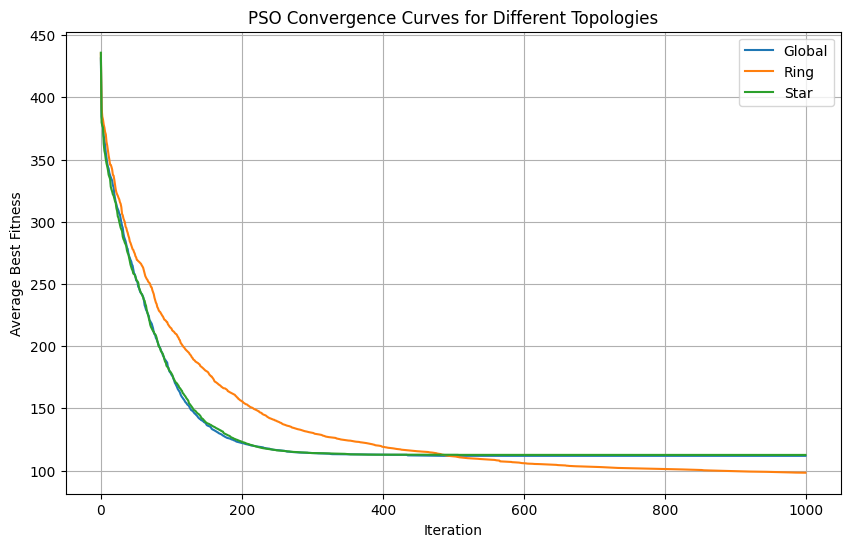

In [ ]:
# Gráficos de Curvas de convergência
plt.figure(figsize=(10, 6))
for topology, curve in convergence_curves.items():
    plt.plot(curve, label=topology.capitalize())

plt.xlabel('Iteration')
plt.ylabel('Average Best Fitness')
plt.title('PSO Convergence Curves for Different Topologies')
plt.legend()
plt.grid(True)
plt.show()